This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# RADOLAN Radar Network

In this chapter the RW-product is shown in WGS84 and the RADOLAN [Polar Stereographic Projection](radolan_grid.ipynb#Polar-Stereographic-Projection). All for the compositing process used radars are extracted from the metadata and plotted with their respective maximum range rings and location information.

In [1]:
import datetime
import wradlib as wrl
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from IPython import get_ipython

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np
from osgeo import osr

In [2]:
import urllib3
import os
import io
import glob
import shutil
import datetime

In [3]:
f = "raa01-rw_10000-latest-dwd---bin.bz2"
opendata_url1 = f"https://opendata.dwd.de/weather/radar/radolan/rw/"

import certifi

http = urllib3.PoolManager(cert_reqs="CERT_REQUIRED", ca_certs=certifi.where())
with http.request(
    "GET", os.path.join(opendata_url1, f), preload_content=False
) as r, open(f, "wb") as out:
    shutil.copyfileobj(r, out)

In [4]:
!bzip2 -df $f

In [5]:
rwdata, rwattrs = wrl.io.read_radolan_composite(f[:-4])

In [6]:
# print the available attributes
print("RW Attributes:", rwattrs)

RW Attributes: {'producttype': 'RW', 'datetime': datetime.datetime(2024, 8, 30, 9, 30), 'radarid': '10000', 'nrow': 900, 'ncol': 900, 'datasize': 1620000, 'formatversion': 3, 'maxrange': '150 km', 'radolanversion': '2.29.1', 'precision': 0.1, 'intervalseconds': 3600, 'radarlocations': ['asb', 'boo', 'hnr', 'umd', 'pro', 'ess', 'fld', 'drs', 'neu', 'nhb', 'oft', 'eis', 'tur', 'isn', 'fbg', 'mem'], 'moduleflag': 1, 'nodataflag': -9999, 'secondary': array([   553, 691193, 691194, ..., 769498, 769499, 770396]), 'nodatamask': array([     0,      1,      2, ..., 809997, 809998, 809999]), 'cluttermask': array([], dtype=int64)}


In [7]:
# mask data
sec = rwattrs["secondary"]
rwdata.flat[sec] = -9999
rwdata = np.ma.masked_equal(rwdata, -9999)

# create radolan projection object
proj_stereo = wrl.georef.create_osr("dwd-radolan")

# create wgs84 projection object
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

# get radolan grid
radolan_grid_xy = wrl.georef.get_radolan_grid(900, 900)
x1 = radolan_grid_xy[:, :, 0]
y1 = radolan_grid_xy[:, :, 1]

# convert to lonlat
radolan_grid_ll = wrl.georef.reproject(
    radolan_grid_xy, src_crs=proj_stereo, trg_crs=proj_wgs
)
lon1 = radolan_grid_ll[:, :, 0]
lat1 = radolan_grid_ll[:, :, 1]

In [8]:
# range array 150 km
print("Max Range: ", rwattrs["maxrange"])
r = np.arange(1, 151) * 1000
# azimuth array 1 degree spacing
az = np.linspace(0, 360, 361)[0:-1]

Max Range:  150 km


In [9]:
radars = dict(
    asb=dict(name="ASR Borkum", lat=53.564011, lon=6.748292, alt=36.0),
    boo=dict(name="Boostedt", lat=54.00438, lon=10.04687, alt=124.56),
    drs=dict(name="Dresden", lat=51.12465, lon=13.76865, alt=263.36),
    eis=dict(name="Eisberg", lat=49.54066, lon=12.40278, alt=798.79),
    emd=dict(name="Emden", lat=53.33872, lon=7.02377, alt=58.0),
    ess=dict(name="Essen", lat=51.40563, lon=6.96712, alt=185.1),
    fbg=dict(name="Feldberg", lat=47.87361, lon=8.00361, alt=1516.1),
    fld=dict(name="Flechtdorf", lat=51.31120, lon=8.802, alt=627.88),
    hnr=dict(name="Hannover", lat=52.46008, lon=9.69452, alt=97.66),
    neu=dict(name="Neuhaus", lat=50.50012, lon=11.13504, alt=878.04),
    nhb=dict(name="Neuheilenbach", lat=50.10965, lon=6.54853, alt=585.84),
    oft=dict(name="Offenthal", lat=49.9847, lon=8.71293, alt=245.8),
    pro=dict(name="Prötzel", lat=52.64867, lon=13.85821, alt=193.92),
    mem=dict(name="Memmingen", lat=48.04214, lon=10.21924, alt=724.4),
    ros=dict(name="Rostock", lat=54.17566, lon=12.05808, alt=37.0),
    isn=dict(name="Isen", lat=48.17470, lon=12.10177, alt=677.77),
    tur=dict(name="Türkheim", lat=48.58528, lon=9.78278, alt=767.62),
    umd=dict(name="Ummendorf", lat=52.16009, lon=11.17609, alt=183.0),
)

In [10]:
def plot_radar(radar, ax, proj):
    site = (radar["lon"], radar["lat"], radar["alt"])

    # build polygons for maxrange rangering
    polygons = wrl.georef.spherical_to_polyvert(r, az, 0, site, crs=proj)
    polygons = polygons[..., 0:2]
    polygons.shape = (len(az), len(r), 5, 2)
    polygons = polygons[:, -1, :, :]

    x_loc, y_loc = wrl.georef.reproject(
        site[0], site[1], src_crs=proj_wgs, trg_crs=proj
    )

    # create PolyCollections and add to respective axes
    polycoll = mpl.collections.PolyCollection(
        polygons, closed=True, edgecolors="r", facecolors="r"
    )
    ax.add_collection(polycoll, autolim=True)

    # plot radar location and information text
    ax.plot(x_loc, y_loc, "r+")
    ax.text(x_loc, y_loc, radar["name"], color="r")

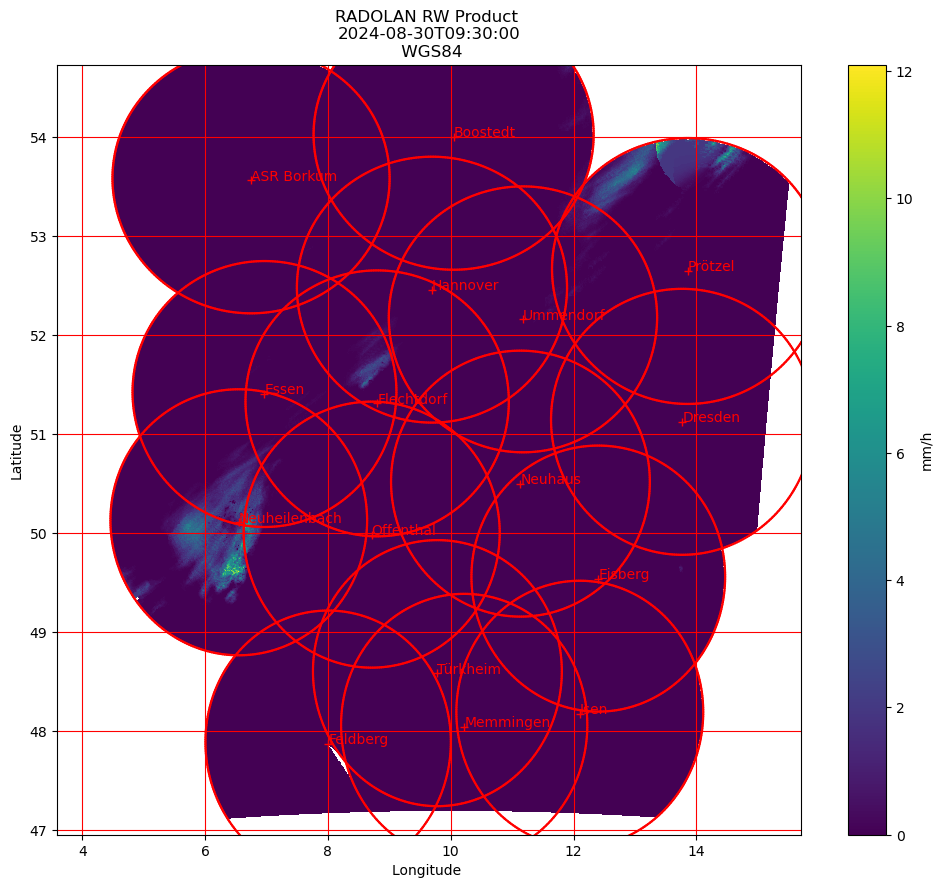

In [11]:
# plot two projections side by side
fig1 = plt.figure(figsize=(12, 10))
ax1 = fig1.add_subplot(111)
pm = ax1.pcolormesh(lon1, lat1, rwdata, cmap="viridis")
cb = fig1.colorbar(pm)
cb.set_label("mm/h")
plt.xlabel("Longitude ")
plt.ylabel("Latitude")
plt.title("RADOLAN RW Product \n" + rwattrs["datetime"].isoformat() + "\n WGS84")
plt.xlim((lon1[0, 0], lon1[-1, -1]))
plt.ylim((lat1[0, 0], lat1[-1, -1]))
plt.grid(color="r")
for radar_id in rwattrs["radarlocations"]:
    # get radar coords etc from dict
    if radar_id == "mhp":
        continue
    radar = radars[radar_id]
    plot_radar(radar, ax1, proj_wgs)

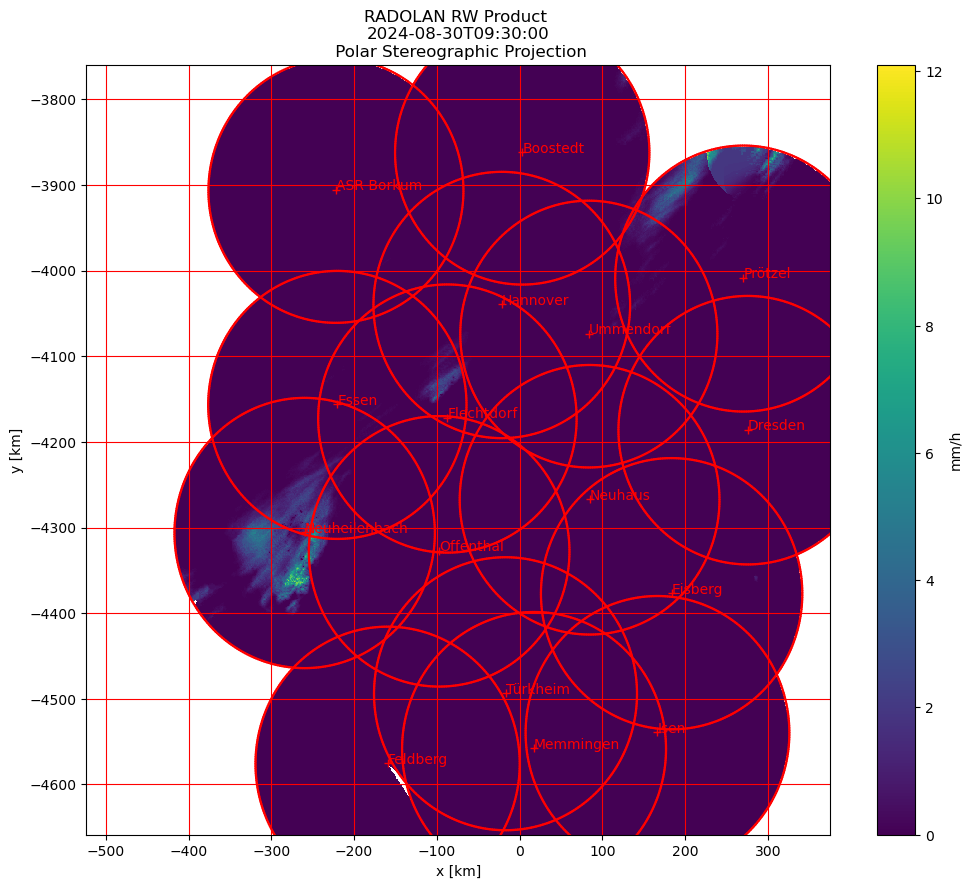

In [12]:
fig2 = plt.figure(figsize=(12, 10))
ax2 = fig2.add_subplot(111)
pm = ax2.pcolormesh(x1, y1, rwdata, cmap="viridis")
cb = fig2.colorbar(pm)
cb.set_label("mm/h")
plt.xlabel("x [km]")
plt.ylabel("y [km]")
plt.title(
    "RADOLAN RW Product \n"
    + rwattrs["datetime"].isoformat()
    + "\n Polar Stereographic Projection"
)
plt.xlim((x1[0, 0], x1[-1, -1]))
plt.ylim((y1[0, 0], y1[-1, -1]))
plt.grid(color="r")
for radar_id in rwattrs["radarlocations"]:
    # get radar coords etc from dict
    if radar_id == "mhp":
        continue
    radar = radars[radar_id]
    plot_radar(radar, ax2, proj_stereo)